# Business Problem

## A) Business Situation

(Kaggle description) Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds min a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts. New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

    -- Business Problem (open question): What's the target destination for the 1st booking of new users?

## B) Business Understanding

    -- Which business model Airbnb operates? 
        -- Marketplace - conect people which offer acomodation to people searching for it)
            -- Supply (people offering accomodation)
                -- Portfolio size
                -- Portfolio density
                -- Average price
                
            -- Demand (people seeking accomodation)
                -- Users quantity
                -- LTV (Lifetime value)
                -- CAC (customer acquisition cost)
            -- Gross Revenue = (Fee * Customer Qty) - CAC 
    
    -- Objective: 
        -- Predict the destination choice for new users (1st booking)
        -- Motivation: Antecipate new users choice in order to offer most assertive ads
        -- Root Cause: Increase gross revenue (through cheaper CAC)
        -- Scope (Closed afirmation)
        -- Stakeholder: CFO/CEO

#### Solution Planning

Solution Overview:
Kind problem: City destination prediction
Potential methods: Classification
Output: 
Steps:
Inputs:
    -- Solution proposal:
        -- Machine Learning model in order to predict 1st AirBnB destination
        -- API:
            -- Input: user + characteristics
            -- Output: user + characteristics + destination prediction



    -- C) Insights
    -- D) Business Results
    -- E) Conclusions (Objectives attained? Problem Solved?)
    -- F) Next Steps
    -- G) Lessons Learned


### Data Fields

Is given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

File descriptions
train_users.csv - the training set of users

test_users.csv - the test set of users

    -- id: user id
    -- date_account_created: the date of account creation
    --- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    -- date_first_booking: date of first booking
    -- gender
    -- age
    -- signup_method
    -- signup_flow: the page a user came to signup up from
    -- language: international language preference
    -- affiliate_channel: what kind of paid marketing
    -- affiliate_provider: where the marketing is e.g. google, craigslist, other
    -- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    -- signup_app
    -- first_device_type
    -- first_browser
    -- country_destination: this is the target variable you are to predict

sessions.csv - web sessions log for users
    -- user_id: to be joined with the column 'id' in users table
    -- action
    -- action_type
    -- action_detail
    -- device_type
    -- secs_elapsed

countries.csv - summary statistics of destination countries in this dataset and their locations

age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

sample_submission.csv - correct format for submitting your predictions

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from scipy                   import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score,balanced_accuracy_score, cohen_kappa_score, classification_report, ConfusionMatrixDisplay
from imblearn                import under_sampling as us
from imblearn                import over_sampling as ovs
from imblearn                import combine as c


from keras import models as ml
from keras import layers as l

### 0.1 Helper Functions

In [2]:
def outlier_detection(data, column):
    
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    
    iqr = q3 - q1

    lo_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    
    outliers = [x for x in data[column] if (x > up_lim) | (x<lo_lim)]
    
    return sorted(outliers)

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 0.2 Loading Data

In [3]:
# in this case, we will proceed with 2 separated datasets and deal with issues then we will decide the granularity to merge
df_raw = pd.read_csv('dataset/train_users.csv')
df_raw.shape
print('The train_users dataset contains {} columns and {} rows'.format(df_raw.shape[1], df_raw.shape[0]))

The train_users dataset contains 16 columns and 213451 rows


In [4]:
df_sessions = pd.read_csv('dataset/sessions.csv')
df_sessions.shape
print('The sessions dataset contains {} columns and {} rows'.format(df_sessions.shape[1], df_sessions.shape[0]))

The sessions dataset contains 6 columns and 10567737 rows


# 1. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 NAs Check 

In [6]:
#users dataset
df1.isna().sum() / df1.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [7]:
#sessions dataset
df_sessions.isna().sum()/df_sessions.shape[0]

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

### 1.1.1 Dealing NAs

In [8]:
# =================== USERS DATASET ==================

#date_first_booking - 58% NAs - 100% in 'NDF' => solution: business knowledge (assumption)
max_date_1st_booking = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(max_date_1st_booking)

#age - 42% NAs in many classes - data normaly distributed => solution: input stastics (mean)
#Assumption: there isnt ppl under 15 and over 120 able to make a booking Outliers removal not appliable - could remove valid entries
df1 = df1[(df1['age']>15)&(df1['age']<120)]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna(avg_age)

#first_affiliate tracked - 2% NAs => solution: categorical data, 2% drop
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# =================== SESSIONS DATASET ==================
#user_id - 0,3% NAs
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action - 0,7% NAs => 100% NA are 'message_post'
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type / action_detail - 10,6% NAs each
df_sessions = df_sessions[~df_sessions['action_type'].isna()]
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed - 1,2% NAs
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [9]:
#users dataset NAs treatment done
df1.isna().sum() / df1.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [10]:
#sessions dataset NAs treatment done
df_sessions.isna().sum()/df_sessions.shape[0]

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.2 Data Type

In [11]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 1.2.1 Change Data Types 

In [12]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])
#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
#age
df1['age'] = df1['age'].astype('int64')

In [13]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.3 Check balanced data

In [14]:
#df1['country_destination'].value_counts()
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.4 Descriptive Statistics

### 1.4.1 Users 

In [15]:
num_att_users= df1.select_dtypes(include=['int32','int64','float64'])

cat_att_users = df1.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

time_att_users = df1.select_dtypes(include=['datetime64[ns]'])

In [16]:
num_att_users.agg(["min","max","mean","median","std","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,age,16.0,115.0,37.405591,34.0,13.939900,2.089718,6.516468
1,signup_flow,0.0,25.0,2.519513,0.0,6.604723,2.705871,5.928298


In [17]:
cat_att_users.drop('id',axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


In [18]:
time_att_users.agg(["min","max","mean","median","std"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std
0,date_account_created,2010-01-02 00:00:00,2014-06-30 00:00:00,2013-06-15 08:50:54.346195200,2013-08-21 00:00:00.000,309 days 11:50:22.561160444
1,timestamp_first_active,2009-05-23 17:48:09,2014-06-30 23:57:54,2013-06-15 12:38:20.219274752,2013-08-20 19:53:34.500,309 days 20:09:23.802178976
2,date_first_booking,2010-01-04 00:00:00,2015-06-29 00:00:00,2014-06-06 05:14:38.423953664,2014-06-30 00:00:00.000,429 days 04:15:53.091295912


### 1.4.2 Sessions 

In [19]:
num_att_sessions= df_sessions.select_dtypes(include=['int32','int64','float64'])

cat_att_sessions = df_sessions.select_dtypes(exclude=['int32','int64','float64','datetime64[ns]'])

time_att_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

In [20]:
num_att_sessions.agg(["min","max","mean","median","std","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

,features,min,max,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


In [21]:
cat_att_sessions.drop('user_id',axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


# 2.0 Data Filtering - Business knowledge

In [22]:
#Filtering based on business assumptions and rules
df2 = df1.copy()
df2_sessions = df_sessions.copy()

## Rows filtering

In [23]:
## === USERS ===
#age filtering 
df2 = df2[(df2['age']>15)&(df2['age']<120)]

In [24]:
## === SESSIONS ===
#secs_elapsed - 0 
df2_sessions = df2_sessions[df2_sessions['secs_elapsed']>0]

## Columns selection

In [25]:
cat_att_list = cat_att_sessions.drop('user_id',axis=1).columns.to_list()

corr_dict = {}

for i in range(len(cat_att_list)):
    
    corr_list = []
    
    for j in range(len(cat_att_list)):
        ref = cat_att_list[i]
        feat = cat_att_list[j]
        corr = cramer_v(cat_att_sessions[ref], cat_att_sessions[feat])
        corr_list.append(corr)

    corr_dict [ref] = corr_list 
    
d = pd.DataFrame(corr_dict)
d.set_index(d.columns)

,action,action_type,action_detail,device_type
action,1.000019,0.952732,0.795156,0.259848
action_type,0.952732,1.000000,0.980625,0.082041
action_detail,0.795156,0.980625,1.000008,0.219622
device_type,0.259848,0.082041,0.219622,1.000001


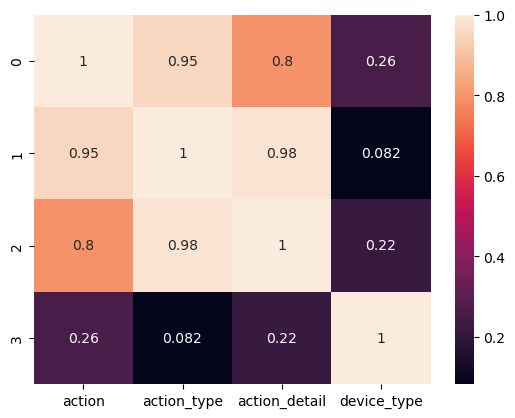

In [26]:
sns.heatmap(d, annot=True);

# 3.0 Feature Engineering

In [27]:
df3 = df2.copy()
df3_sessions = df2_sessions.copy()

In [28]:
#days from 1st active up to 1st booking
df3['date_first_activation'] = pd.to_datetime(df3['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df3['days_from_first_until_booking'] = (df3['date_first_booking'] - df3['date_first_activation']).apply(lambda x: x.days)

#days from 1st active up to account creation
df3['days_from_activation_until_acc_creation'] = (df3['date_account_created'] - df3['date_first_activation']).apply(lambda x: x.days)

#days from account creation up to 1st booking
df3['days_from_acc_until_booking'] = (df3['date_first_booking'] - df3['date_account_created']).apply(lambda x: x.days)

#==== date first activation ====
#day
df3['day_first_activation'] = df3['date_first_activation'].dt.day
#day of week
df3['day_week_first_activation'] = df3['date_first_activation'].dt.dayofweek
#month
df3['month_first_activation'] = df3['date_first_activation'].dt.month
#week of year
df3['week_year_first_activation'] = df3['date_first_activation'].dt.isocalendar().week.astype('int64')
#year
df3['year_first_activation'] = df3['date_first_activation'].dt.year

#==== date first booking ====
#day
df3['day_first_booking'] = df3['date_first_booking'].dt.day
#day of week
df3['day_week_first_booking'] = df3['date_first_booking'].dt.dayofweek
#month
df3['month_first_booking'] = df3['date_first_booking'].dt.month
#week of year
df3['week_year_first_booking'] = df3['date_first_booking'].dt.isocalendar().week.astype('int64')
#year
df3['year_first_booking'] = df3['date_first_booking'].dt.year

#==== date first booking ====

#day
df3['day_acc_created'] = df3['date_account_created'].dt.day
#day of week
df3['day_week_acc_created'] = df3['date_account_created'].dt.dayofweek
#month
df3['month_acc_created'] = df3['date_account_created'].dt.month
#week of year
df3['week_year_acc_created'] = df3['date_account_created'].dt.isocalendar().week.astype('int64')
#year
df3['year_acc_created'] = df3['date_account_created'].dt.year


In [29]:
cols_derived = ['date_account_created', 'date_first_booking', 'timestamp_first_active', 'date_first_activation' ]
df3.drop(cols_derived, axis=1, inplace=True)

# 4.0 Balance Data

In [30]:
df4 = df3.copy()

In [31]:
df41 = df4.drop(columns='id')

## 4.1 Undersampling - Random

In [32]:
#define sampler
rus = us.RandomUnderSampler(sampling_strategy='auto',random_state=32)

#apply sampler
X_under, y_under = rus.fit_resample(df4, df4['country_destination'])

In [33]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [34]:
y_under.value_counts()

AU       157
CA       157
DE       157
ES       157
FR       157
GB       157
IT       157
NDF      157
NL       157
PT       157
US       157
other    157
Name: country_destination, dtype: int64

## 4.2 Oversampling - Random

In [35]:
#define sampler
ros = ovs.RandomOverSampler(sampling_strategy='all',random_state=32)

#apply sampler
X_over, y_over = ros.fit_resample(df4,df4['country_destination'])

In [36]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [37]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## 4.3 Over + Under - SMOTE + TomekLink

In [38]:
# Prepare Variables to SMOTE -> split cols, keep numericals as original, encode categorical (except target var)
ohe = OneHotEncoder()

# Numerical Vars  
col_num = df41.select_dtypes(include=['int64','float64']).columns.tolist()

# Categorical Vars
col_cat = df41.select_dtypes(exclude=['int64','float64','datetime64[ns]']).drop(columns='country_destination', axis=1).columns.tolist()

# Encoding Cat
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

#Join back
df42 = pd.concat([df41[col_num], df4_dummy],axis=1)


In [39]:
# # get dummies is ticky to return back
# df422 = df41.drop(columns='country_destination', axis=1)
# df422 = pd.get_dummies(df422)df4['country_destination'].value_counts().to_dict()

In [40]:
#ratio balanced => empirical
balanced_ratio = {'NDF': 54852,
                  'US': 48057,
                  'other': 6*7511,
                  'FR': 12*3669,
                  'IT': 20*2014,
                  'GB': 30*1758,
                  'ES': 30*1685,
                  'CA': 40*1064,
                  'DE': 45*841,
                  'NL': 80*595,
                  'AU': 85*433,
                  'PT': 300*157}
balanced_ratio

{'NDF': 54852,
 'US': 48057,
 'other': 45066,
 'FR': 44028,
 'IT': 40280,
 'GB': 52740,
 'ES': 50550,
 'CA': 42560,
 'DE': 37845,
 'NL': 47600,
 'AU': 36805,
 'PT': 47100}

In [41]:
smt = c.SMOTETomek(sampling_strategy=balanced_ratio, random_state=32, n_jobs=-1)

X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

In [42]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [43]:
y_smt.value_counts()

NDF      54850
GB       52691
ES       50508
NL       47598
US       47547
PT       47100
other    44761
FR       43869
CA       42543
IT       40201
DE       37830
AU       36803
Name: country_destination, dtype: int64

In [44]:
# Numerical vars
df43 = X_smt[col_num]
# Categ Var unencoded
df44 = X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

#balanced dataframe
df46 = pd.concat([df43, df45], axis=1)
df46['country_destination'] = y_smt

In [45]:
df46.shape

(546301, 30)

In [46]:
df41.shape

(122636, 30)

In [47]:
df46['country_destination'].value_counts()

NDF      54850
GB       52691
ES       50508
NL       47598
US       47547
PT       47100
other    44761
FR       43869
CA       42543
IT       40201
DE       37830
AU       36803
Name: country_destination, dtype: int64

In [48]:
df41['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

# 5.0 Exploratory Data Analysis

### 5.1 Univariate Analysis (Balanced Dataset)

In [ ]:
df5 = df4.copy()

### 5.2 Bivariate Analysis (Unbalanced Dataset)

In [ ]:
df51 = df46.copy()

# 6.0 Data Preparation

In [49]:
#df5 = df4.copy()

In [50]:
df5 = df46.copy()

In [51]:
#split dataset training/validation
X = df5.drop(columns='country_destination')
y = df5['country_destination'].copy()

In [52]:
#X.drop(columns='id',axis=1, inplace=True)

aux= pd.get_dummies(X)
X = pd.concat([df4['id'],aux],axis=1)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=32)

# 7.0 Feature Selection

In [54]:
cols_drop = ['id']
X_train = X_train.drop(cols_drop, axis=1)
X_val = X_val.drop(cols_drop, axis=1)

# 8.0 ML Modeling

### 8.1 Baseline Model

In [55]:
#build a random model - baseline

#values to pick ramdomly
country_dest_list = sorted(df4['country_destination'].unique())

#classes presence
target_weights = df4['country_destination'].value_counts(normalize=True).sort_index().to_list()

#size 
k_num = y_val.shape[0]

yhat_baseline = random.choices(population=country_dest_list, weights=target_weights, k=k_num)

Accuracy 0.0919907377746863
 Balanced Accuracy 0.0832151356186192
 Kappa score -6.873967498499667e-05
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7415
          CA       0.08      0.01      0.02      8579
          DE       0.07      0.01      0.01      7433
          ES       0.10      0.01      0.02     10020
          FR       0.08      0.03      0.04      8751
          GB       0.10      0.01      0.03     10617
          IT       0.07      0.01      0.02      8078
         NDF       0.10      0.45      0.16     10900
          NL       0.07      0.00      0.01      9564
          PT       0.10      0.00      0.00      9458
          US       0.09      0.39      0.14      9557
       other       0.08      0.06      0.07      8889

    accuracy                           0.09    109261
   macro avg       0.08      0.08      0.04    109261
weighted avg       0.08      0.09      0.05    109261



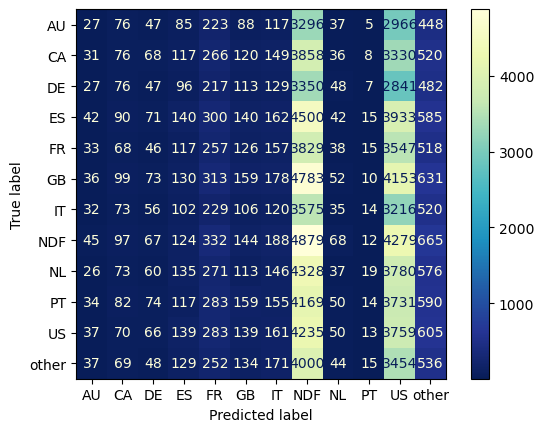

In [56]:
#acuracy
acc_base = accuracy_score(y_val, yhat_baseline)
print('Accuracy {}'.format(acc_base))

#balanced accuracy
balanced_acc_base = balanced_accuracy_score(y_val, yhat_baseline)
print(' Balanced Accuracy {}'.format(balanced_acc_base))

#Kappa score - estimators agreement
kappa_base = cohen_kappa_score(y_val, yhat_baseline)
print(' Kappa score {}'.format(kappa_base))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, yhat_baseline, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val, yhat_baseline))

### 8.2 Neural Network MLP 

In [57]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [58]:
print( 'Number of Rows: {}'.format( X_train.shape[0] ) )
print( 'Number of Features: {}'.format( X_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

Number of Rows: 437040
Number of Features: 138
Number of Classes: 12


In [60]:
#model definition
model = ml.Sequential()

#1st layer
model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))

#output layer
model.add(l.Dense(12, activation='softmax'))
          
#model compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
          
#train model
model.fit(X_train,y_train_nn, epochs=100)

#prediction
pred_nn = model.predict(X_val)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn) 

#prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Epoch 1/100
13658/13658 [==============================] - 15s 934us/step - loss: 6.1545 - accuracy: 0.1148
Epoch 2/100
13658/13658 [==============================] - 12s 904us/step - loss: 2.4254 - accuracy: 0.1248
Epoch 3/100
13658/13658 [==============================] - 12s 894us/step - loss: 2.3916 - accuracy: 0.1260
Epoch 4/100
13658/13658 [==============================] - 15s 1ms/step - loss: 2.3906 - accuracy: 0.1260
Epoch 5/100
13658/13658 [==============================] - 14s 1ms/step - loss: 2.3905 - accuracy: 0.1262
Epoch 6/100
13658/13658 [==============================] - 14s 1ms/step - loss: 2.3901 - accuracy: 0.1262
Epoch 7/100
13658/13658 [==============================] - 14s 1ms/step - loss: 2.3898 - accuracy: 0.1263
Epoch 8/100
13658/13658 [==============================] - 15s 1ms/step - loss: 2.3895 - accuracy: 0.1259
Epoch 9/100
13658/13658 [==============================] - 14s 1ms/step - loss: 2.3894 - accuracy: 0.1262
Epoch 10/100
13658/13658 [==============

13658/13658 [==============================] - 13s 933us/step - loss: 2.3881 - accuracy: 0.1263
Epoch 77/100
13658/13658 [==============================] - 13s 927us/step - loss: 2.3879 - accuracy: 0.1259
Epoch 78/100
13658/13658 [==============================] - 13s 980us/step - loss: 2.3882 - accuracy: 0.1258
Epoch 79/100
13658/13658 [==============================] - 12s 863us/step - loss: 2.3880 - accuracy: 0.1262
Epoch 80/100
13658/13658 [==============================] - 13s 929us/step - loss: 2.3879 - accuracy: 0.1265
Epoch 81/100
13658/13658 [==============================] - 13s 918us/step - loss: 2.3882 - accuracy: 0.1258
Epoch 82/100
13658/13658 [==============================] - 13s 927us/step - loss: 2.3880 - accuracy: 0.1266
Epoch 83/100
13658/13658 [==============================] - 12s 873us/step - loss: 2.3880 - accuracy: 0.1262
Epoch 84/100
13658/13658 [==============================] - 13s 932us/step - loss: 2.3881 - accuracy: 0.1261
Epoch 85/100
13658/13658 [======

### 8.2.1 NN Performance

Accuracy 0.12884743870182408
 Balanced Accuracy 0.12115851113315629
 Kappa score 0.037695162603624044
              precision    recall  f1-score   support

          AU       0.33      0.43      0.37      7415
          CA       0.00      0.00      0.00      8579
          DE       0.00      0.00      0.00      7433
          ES       0.00      0.00      0.00     10020
          FR       0.00      0.00      0.00      8751
          GB       0.11      0.93      0.19     10617
          IT       0.00      0.00      0.00      8078
         NDF       0.13      0.09      0.11     10900
          NL       0.00      0.00      0.00      9564
          PT       0.00      0.00      0.00      9458
          US       0.00      0.00      0.00      9557
       other       0.00      0.00      0.00      8889

    accuracy                           0.13    109261
   macro avg       0.05      0.12      0.06    109261
weighted avg       0.05      0.13      0.05    109261



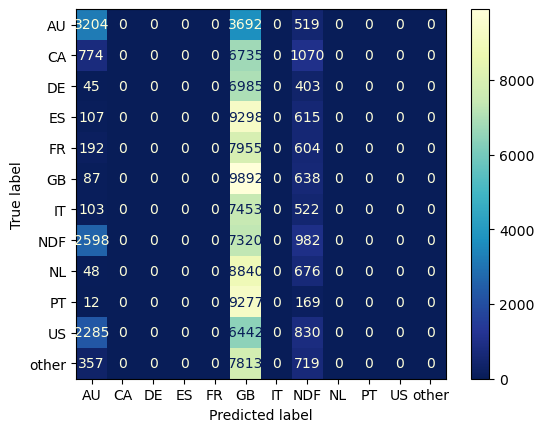

In [61]:
#acuracy
acc_nn = accuracy_score(y_val_nn, yhat_nn)
print('Accuracy {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = balanced_accuracy_score(y_val_nn, yhat_nn)
print(' Balanced Accuracy {}'.format(balanced_acc_nn))

#Kappa score - estimators agreement
kappa = cohen_kappa_score(y_val_nn, yhat_nn)
print(' Kappa score {}'.format(kappa))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_nn, yhat_nn, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val_nn, yhat_nn))

### 8.2.2 NN Performance - Cross validation

In [62]:
#generate k-fold
n_folds=5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=32)
balanced_acc_list = []
kappa_list = []
i=1

for train_ix, val_ix in kfold.split(X_train, y_train):

    print('Fold {}/{}'.format(i,n_folds))
    
    #define fold
    X_train_cv = X_train.iloc[train_ix]
    y_train_cv = y_train.iloc[train_ix]

    X_val_cv = X_train.iloc[val_ix]
    y_val_cv = y_train.iloc[val_ix]


    #target one-hot encoding
    ohe = OneHotEncoder()
    y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1,1)).toarray()
    
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense( 256, input_dim=X_train_cv.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax' ))

    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #training model
    model.fit(X_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

    #prediction
    pred_nn_cv = model.predict(X_val_cv)
    yhat_nn_cv = ohe.inverse_transform(pred_nn_cv)
    
    y_val_nn_cv = y_val_cv.to_numpy()
    yhat_nn_cv = yhat_nn_cv.reshape(1,-1)[0]
    
    #balanced accuracy
    balanced_acc_nn = balanced_accuracy_score(y_val_nn_cv, yhat_nn_cv)
    balanced_acc_list.append(balanced_acc_nn)
    
    #Kappa score - estimators agreement
    kappa = cohen_kappa_score(y_val_nn_cv, yhat_nn_cv)
    kappa_list.append(kappa)
    
    i+=1


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [63]:
print('Balanced Accuracy after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(balanced_acc_list),2), 
                                                                         np.round(np.std(balanced_acc_list),4)))
print('Kappa Score after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(kappa_list),4), 
                                                                         np.round(np.std(kappa_list),4)))

Balanced Accuracy after 5 K-Folds CV is 0.11 ± 0.0059
Kappa Score after 5 K-Folds CV is 0.0337 ± 0.0029
